# Глава 2

In [446]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import time

from tqdm import tqdm

from typing import List, Set

In [447]:
# generate all sequences of length l
def generate(l):
    res = []
    
    for i in range(1, 2**l):
        b = bin(i)[2:]
        b = '0' * (l - len(b)) + b
        b = np.array(list(map(lambda x: int(x), b)))
        res.append(b)
        
    return np.array(res)

## Задание 14

Будем пользоватся **Свойством 2.2**: $\rho = max_{\rho} \rho(s)$

In [365]:
def findRadius(H, title):
    r = 0
    for e in generate(H.shape[1]):
        r = max(r, np.sum(np.dot(e, H.T) % 2))
    
    print("{}: radius = {}".format(title, r))

In [366]:
H1 = np.array([
    [1, 1, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 0, 0, 1, 0, 0],
    [1, 0, 0, 0, 1, 0],
    [1, 0, 0, 0, 0, 1]
])
H2 = np.array([
    [1, 1, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 1, 0, 0, 1, 0],
    [1, 1, 1, 1, 1, 1]
])
H3 = np.array([
    [0, 1, 1, 1, 0, 0], 
    [1, 0, 1, 0, 1, 0], 
    [1, 1, 0, 0, 0, 1]
])
H4 = np.array([
    [1, 0, 1, 0, 1, 0],
    [0, 1, 0, 1, 0, 1]
])
H5 = np.array([
    [1, 1, 1, 1, 1, 1]
])

In [367]:
findRadius(H1, "n = 6, k = 1, d = 6")

n = 6, k = 1, d = 6: radius = 5


In [368]:
findRadius(H2, "n = 6, k = 2, d = 4")

n = 6, k = 2, d = 4: radius = 4


In [369]:
findRadius(H3, "n = 6, k = 3, d = 3")

n = 6, k = 3, d = 3: radius = 3


In [370]:
findRadius(H4, "n = 6, k = 4, d = 2")

n = 6, k = 4, d = 2: radius = 2


In [371]:
findRadius(H5, "n = 6, k = 5, d = 2")

n = 6, k = 5, d = 2: radius = 1


Эти коды нельзя улучшить с точки зрения радиуса покрытия так как: $\rho \le n - k$. Для последнего кода (n = 6, k = 5, d = 2): $\rho = 0$ и его тоже нельзя улучшить.

# Задание 15

In [372]:
BitWord = List[int]

# computes difference of two arrays of bit-word
def diff(X: List[BitWord], Y: List[BitWord]) -> List[BitWord]:
    res = []
    for x in X:
        diff = False
        for y in Y:
            if np.all(np.equal(x, y)):
                diff = True
                break
        if not diff:
            res.append(x)
    return np.array(res)

In [442]:
class Code:
    def __init__(self, H: List[List[int]], d: int):
        self.H = H
        self.n = H.shape[1]
        self.k = H.shape[1] - H.shape[0]
        self.r = self.n - self.k
        self.d = d
        self.all_words = generate(self.n)
        self.all_words_with_zero = np.vstack((self.all_words, np.zeros(self.n)))
        self.syndrom_matrix = self.get_syndrom_matrix() 
        self.code_words = self.get_code_words()
        self.Z = self.getZ()
        self.indexes_stored = np.arange(self.n)
    
    def get_code_words(self):
        res = []
        for c in self.all_words_with_zero:
            if np.all(np.dot(c, self.H.T) % 2 == 0):
                res.append(c)
        return res
    
    def brute_force_decode(self, y: BitWord) -> BitWord:
        mn = self.n
        c = np.zeros(self.n)
        for cur in self.all_words_with_zero:
            if (np.dot(cur, self.H.T) % 2 == 0) and (np.sum((2 + cur - y) % 2) < mn):
                mn = np.sum((2 + cur - y) % 2)
                c = cur
        return c
        
    # returns e with minimal weigh such that s = e * H.T
    def get_min_error_weight(self, s: List[int]) -> int:
        res = self.n
        for e in self.all_words:
            if np.all(s == (np.dot(e, self.H.T) % 2)):
                res = min(res, np.sum(e))
        return res


    # return 
    def get_syndrom_matrix(self):
        res = []

        a_s = generate(self.r)
        
        for s in a_s:
            m = self.get_min_error_weight(s)

            for e in self.all_words: # errors
                if np.all(s == (np.dot(e, self.H.T) % 2)) and (np.sum(e) == m):
                    res.append((s, e))
                    break
        return res
                
    
    # decode y using syndrom matrix decoding
    def syndrom_decode(self, y: BitWord) -> BitWord:
        syndrom = np.dot(y, self.H.T) % 2
        
        for se in self.syndrom_matrix:
            if (np.all(np.equal(syndrom, se[0]))):
                return ((y + 2) - se[1]) % 2

        return y # it's code word
                
    # get set of words such that word is decoding into c using syndrom decoding.
    def getR(self, c: BitWord):
        R = []
        for w in self.all_words_with_zero:
            if (np.all(np.equal(c, self.syndrom_decode(w)))):
                R.append(w)
        return R

    # get set of words such that inversion of one symbol gives word from R(c)
    def getD(self, c: BitWord) -> List[BitWord]:
        R = self.getR(c)
        D = []
        for w in self.all_words_with_zero:
            # inversion of one bit
            if np.min(np.apply_along_axis(lambda x : np.sum((2 + x - w) % 2), 1, R)) == 1:                 
                D.append(w)
        return D
            
    def getZ(self):
        D0 = self.getD(np.zeros(self.n))

        intersected = [] # слова для которых R(c) пересекается с D(0)

        for c in self.all_words_with_zero:
            if np.sum(np.dot(c, self.H.T) % 2) != 0:
                continue
            # теперь с - кодовое слово

            if len(diff(D0, self.getR(c))) != len(D0):
                intersected.append(c)
            
        minimal_set = []
        for i in range(len(intersected)):
            current_intersection = []
            for j in range(len(intersected)):
                if i == j:
                    continue
                current_intersection.extend(self.getR(intersected[j]))
                
            if len(diff(D0, current_intersection)) != len(D0):
                minimal_set.append(intersected[i]) # this item should be in Z

        return minimal_set
    
    def zero_neighbor_decode(self, y):
        c = np.zeros(self.n)
        improved = True
        while (improved):
            current_weight = np.sum(y)
            
            improved = False
            for z in self.Z:
                if np.sum((y + z) % 2) < current_weight:
                    y = (y + z) % 2
                    c = (c + z) % 2
                    improved = True
                    break
        return c
    
    def info_decode(self, y):
        d_opt = np.sum(y)
        c_hat = np.zeros(self.n)
        indexes_stored = np.arange(self.n)
        for i in range(20):
            np.random.shuffle(self.indexes_stored)
            indexes = self.indexes_stored[:self.k]
            
            for c in self.code_words:
                if np.all(y[indexes] == c[indexes]): # совпадает на выбранных позициях
                    if np.sum((2 + y - c) % 2) < d_opt:
                        d_opt = np.sum((2 + y - c) % 2)
                        c_hat = c
        return c_hat

In [443]:
c1 = Code(H1, 6)
c2 = Code(H2, 4)
c3 = Code(H3, 3)
c4 = Code(H4, 2)
c5 = Code(H5, 2)

Приведем множества соседей нулевого слова для кодов из задания 1:

In [375]:
c2.Z

[array([ 0.,  1.,  1.,  1.,  1.,  0.]),
 array([ 1.,  0.,  1.,  1.,  0.,  1.]),
 array([ 1.,  1.,  0.,  0.,  1.,  1.])]

In [376]:
c3.Z

[array([ 0.,  0.,  1.,  1.,  1.,  0.]),
 array([ 0.,  1.,  0.,  1.,  0.,  1.]),
 array([ 0.,  1.,  1.,  0.,  1.,  1.]),
 array([ 1.,  0.,  0.,  0.,  1.,  1.]),
 array([ 1.,  0.,  1.,  1.,  0.,  1.]),
 array([ 1.,  1.,  1.,  0.,  0.,  0.])]

In [377]:
c4.Z

[array([ 0.,  0.,  0.,  1.,  0.,  1.]),
 array([ 0.,  0.,  1.,  0.,  1.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 1.,  0.,  0.,  0.,  1.,  0.])]

In [378]:
c5.Z

[array([ 0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 0.,  0.,  0.,  1.,  0.,  1.]),
 array([ 0.,  0.,  1.,  0.,  0.,  1.]),
 array([ 0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 1.,  0.,  0.,  0.,  0.,  1.])]

# Примеры работы алгоритмов

In [379]:
print(c5.syndrom_decode(np.array([0,0,0,1,1,1])))
print(c5.brute_force_decode(np.array([0,0,0,1,1,1])))
print(c5.zero_neighbor_decode(np.array([0,0,0,1,1,1])))

[0 0 0 1 1 0]
[ 0.  0.  0.  0.  1.  1.]
[ 0.  0.  0.  0.  1.  1.]


# Сравнение производительности

In [380]:
test_data = []
while len(test_data) < 1e6:
    test_data.extend(generate(c5.n))

In [381]:
def measure(decode, test_data: List[BitWord], iters: int) -> int:
    start = time.time()
    
    for i in range(0, iters):
        decode(test_data[i])
    
    return (time.time() - start)

In [382]:
brute_force_plt = np.array([measure(c5.brute_force_decode, test_data, 10**p) for p in range(1, 5)]) 
syndrom_plt = np.array([measure(c5.syndrom_decode, test_data, 10**p) for p in range(1, 5)])
zero_neighbours = np.array([measure(c5.zero_neighbor_decode, test_data, 10**p) for p in range(1, 5)])

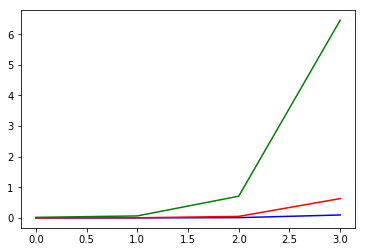

In [383]:
plt.plot(brute_force_plt, color='g')
plt.plot(syndrom_plt, color='b')
plt.plot(zero_neighbours, color='r')
plt.show()

Алгоритм декодирования перебором естественно самый медленный. Алгоритм синдромного декодирования самый быстрый, однако он хранит в памяти очень много дополнительной информации.

# Задание 16

Алгоритм написан выше в классе, однако приведу его здесь

In [455]:
def info_decode(self, y):
        d_opt = np.sum(y)
        c_hat = np.zeros(self.n)
        indexes_stored = np.arange(self.n)
        for i in range(20):
            np.random.shuffle(self.indexes_stored)
            indexes = self.indexes_stored[:self.k]
            
            for c in self.code_words:
                if np.all(y[indexes] == c[indexes]): # совпадает на выбранных позициях
                    if np.sum((2 + y - c) % 2) < d_opt:
                        d_opt = np.sum((2 + y - c) % 2)
                        c_hat = c
        return c_hat

In [448]:
brute_force_plt = np.array([measure(c5.brute_force_decode, test_data, 10**p) for p in tqdm(range(1, 5))]) 
info_plt = np.array([measure(c5.info_decode, test_data, 10**p) for p in tqdm(range(1, 5))]) 

100%|██████████| 4/4 [00:38<00:00, 11.30s/it]


In [451]:
syndrom_plt = np.array([measure(c5.syndrom_decode, test_data, 10**p) for p in range(1, 5)])
zero_neighbours = np.array([measure(c5.zero_neighbor_decode, test_data, 10**p) for p in range(1, 5)])

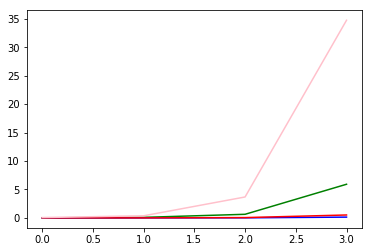

In [454]:
plt.plot(brute_force_plt, color='g')
plt.plot(syndrom_plt, color='b')
plt.plot(zero_neighbours, color='r')
plt.plot(info_plt, color='pink')
plt.show()

Алгоритм получился довольно таки медленным, что неудивительно.